In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext watermark
%watermark -p torch,pandas,numpy -m

torch 0.4.1
pandas 0.22.0
numpy 1.15.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.10.0-32-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from pathlib import Path
import itertools
from collections import Counter
from functools import partial, reduce

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support
from fastai.text import (
    TextDataset, SortishSampler, SortSampler, DataLoader, ModelData, seq2seq_reg, 
    RNN_Learner, TextModel, to_gpu
)
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from fastai.text import accuracy
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import sentencepiece as spm

from cnlp.fastai_extended import (
    LanguageModelLoader, LanguageModelData, get_transformer_classifier, 
    TransformerTextModel, TruncatedTransformerLearner
)

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [4]:
path = Path("../data/cache/lm_unigram_transformer_douban/")
path.mkdir(parents=True, exist_ok=True)

## Utility Function(s)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Import And Tokenize Comments and Ratings

In [6]:
df_ratings = pd.read_csv("../data/ratings_word.csv")
df_ratings.head()

,comment,rating
0,别 拿 矫揉造作 的 资产阶级 情调 麻醉 中国 人民 ！,1
1,文青 们 向往 的 生活 ， 可是 生活 中 没有 了 喜怒哀乐 ， 没有 了 问题 与 冲...,2
2,自由 也许 在 大理 ， 生活 确实 在 别处 。,3
3,原来 八旬 是 小四 的 老公 ， 小 彩旗 的 爹 ， 杨丽萍 的 妹夫 。,3
4,关于 大理 的 蓝光 旅游 宣传片 。,3


In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=888)
train_idx, test_idx = next(sss.split(df_ratings, df_ratings.rating))
df_train = df_ratings.iloc[train_idx].copy()
df_test = df_ratings.iloc[test_idx].copy()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=888)
val_idx, test_idx = next(sss.split(df_test, df_test.rating))
df_val = df_test.iloc[val_idx].copy()
df_test = df_test.iloc[test_idx].copy()
del df_ratings

In [8]:
UNK = 0
BEG = 1
EMB_DIM = 300

### Use the Refitted Vocabulary
#### Investigate Vocabulary Differences

In [9]:
itos_orig = []
with open("../data/unigram_model.vocab", mode="r", encoding="utf-8") as f:
    for line in f.readlines():
        itos_orig.append(line.split("\t")[0])
itos = []
with open("../data/rating_unigram_model.vocab", mode="r", encoding="utf-8") as f:
    for line in f.readlines():
        itos.append(line.split("\t")[0])
n_toks = len(itos)
n_toks

7500

In [10]:
itos[:5]

['<unk>', '<s>', '</s>', '▁,', '▁的']

In [11]:
mapping = {s: idx for idx, s in enumerate(itos)}
mapping_orig = {s: idx for idx, s in enumerate(itos_orig)}

In [12]:
voc_diff = set(itos) - set(itos_orig)
print(len(voc_diff), len(itos))
sorted([(x, mapping[x]) for x in list(voc_diff)], key=lambda x: x[1], reverse=True)[:50]

2823 7500


[('婪', 7499),
 ('★', 7491),
 ('】', 7490),
 ('兀', 7489),
 ('☆', 7488),
 ('葩', 7487),
 ('̄', 7486),
 ('喂', 7485),
 ('咱', 7484),
 ('匆', 7482),
 ('蝴', 7478),
 ('袱', 7477),
 ('寥', 7476),
 ('疙', 7475),
 ('痨', 7474),
 ('【', 7470),
 (']', 7469),
 ('*', 7468),
 ('扔', 7466),
 ('窒', 7464),
 ('漓', 7462),
 ('肮', 7459),
 ('@', 7458),
 ('[', 7457),
 ('驭', 7455),
 ('渲', 7453),
 ('樟', 7452),
 ('跪', 7451),
 ('甩', 7448),
 ('噱', 7445),
 ('暧', 7440),
 ('谑', 7439),
 ('蹩', 7435),
 ('讶', 7434),
 ('戛', 7431),
 ('╭', 7428),
 ('娴', 7423),
 ('蹋', 7422),
 ('疵', 7403),
 ('潇', 7401),
 ('尴', 7400),
 ('烘', 7390),
 ('陌', 7383),
 ('馨', 7381),
 ('瑕', 7377),
 ('>', 7373),
 ('唏', 7372),
 ('俐', 7371),
 ('谬', 7369),
 ('缚', 7359)]

#### Tokenize

In [13]:
sp = spm.SentencePieceProcessor()
sp.Load("../data/rating_unigram_model.model")

True

In [14]:
results = []
tokens_train, tokens_val, tokens_test = [], [], []
for df, tokens in zip((df_train, df_val, df_test), (tokens_train, tokens_val, tokens_test)) :
    for i, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        tokens.append(np.array([BEG] + sp.EncodeAsIds(row["comment"])))
assert len(tokens_train) == df_train.shape[0]        

In [48]:
joblib.dump([tokens_train, tokens_val, tokens_test], "../data/cache/rating_unigram_tokens.pkl")

['../data/cache/rating_unigram_tokens.pkl']

In [15]:
tokens_val[0]

array([   1,  163,  149,   99, 1064, 1412])

In [16]:
df_val.iloc[0]

comment    男 主角 像 卡卡
rating             2
Name: 681247, dtype: object

#### Prepare the embedding matrix

In [18]:
MODEL_PATH = "../data/cache/lm_unigram_transformer/models/lm_transformer.h5"
weights = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
assert weights['0.embed.weight'].shape[1] == EMB_DIM
weights['0.embed.weight'].shape

torch.Size([7700, 300])

In [19]:
new_matrix = np.zeros((n_toks + 200, EMB_DIM))
hits = 0
for i, w in enumerate(itos):
    if w in mapping_orig:
        new_matrix[i] = weights['0.embed.weight'][mapping_orig[w]]
        hits += 1
new_matrix[BEG, :] = 0
hits, hits *100 / len(itos[3:])

(4677, 62.38495398159264)

In [20]:
new_matrix[n_toks:, :] = weights['0.embed.weight'][-200:, :]

In [21]:
weights['0.embed.weight'] = T(new_matrix)
weights['1.weight'] = T(np.copy(new_matrix)[:-200, :])
weights['0.embed.weight'].shape

torch.Size([7700, 300])

## Languange Model

In [21]:
bs = 32
bptt = 200
target_length = 195
trn_dl = LanguageModelLoader(np.concatenate(tokens_train), bs, bptt, target_length=target_length, batch_first=True)
val_dl = LanguageModelLoader(np.concatenate(tokens_val), bs, bptt, target_length=target_length, batch_first=True)

In [22]:
model_data = LanguageModelData(
    path, pad_idx=2, n_tok=n_toks, trn_dl=trn_dl, val_dl=val_dl, bs=bs, bptt=bptt
)

In [23]:
learner = model_data.get_transformer_model(
    partial(Adam, betas=(0.8, 0.999)),
    max_seq_len=trn_dl.max_possible_seq_len,
    emb_sz=EMB_DIM,
    n_head=12,
    n_layer=3,
    embd_pdrop=0.05,
    attn_pdrop=0.1,
    resid_pdrop=0.1
)

In [24]:
learner.model.load_state_dict(weights)
assert torch.equal(learner.model[0].embed.weight[:-200, :], learner.model[1].weight)

In [25]:
next(iter(trn_dl))[0].size()

torch.Size([32, 200])

In [26]:
learner.get_layer_groups()

[Embedding(7700, 300, padding_idx=2), Block(
   (attn): Attention(
     (c_attn): Linear(in_features=300, out_features=900, bias=True)
     (c_proj): Linear(in_features=300, out_features=300, bias=True)
     (attn_dropout): Dropout(p=0.1)
     (resid_dropout): Dropout(p=0.1)
   )
   (ln_1): LayerNorm()
   (mlp): MLP(
     (c_fc): Linear(in_features=300, out_features=1200, bias=True)
     (c_proj): Linear(in_features=1200, out_features=300, bias=True)
     (dropout): Dropout(p=0.1)
   )
   (ln_2): LayerNorm()
 ), Block(
   (attn): Attention(
     (c_attn): Linear(in_features=300, out_features=900, bias=True)
     (c_proj): Linear(in_features=300, out_features=300, bias=True)
     (attn_dropout): Dropout(p=0.1)
     (resid_dropout): Dropout(p=0.1)
   )
   (ln_1): LayerNorm()
   (mlp): MLP(
     (c_fc): Linear(in_features=300, out_features=1200, bias=True)
     (c_proj): Linear(in_features=1200, out_features=300, bias=True)
     (dropout): Dropout(p=0.1)
   )
   (ln_2): LayerNorm()
 ), Bl

In [39]:
from fastai.core import set_trainable
set_trainable(learner.model, False)
set_trainable(learner.get_layer_groups()[0], True)
set_trainable(learner.get_layer_groups()[-1], True)
assert learner.model[0].blocks[0].trainable == False
assert learner.model[0].blocks[0].attn.c_proj.weight.requires_grad == False
assert learner.model[1].weight.requires_grad == True
assert learner.model[1].trainable == True
assert learner.model[0].embed.trainable == True
assert learner.model[0].embed.weight.requires_grad == True

In [41]:
lr=1e-3
lrs = lr
learner.fit(lrs/2, 1, wds=0, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss                                
    0      5.39272    5.275459  



[5.275458800641796]

In [42]:
learner.save('lm_last_ft')

In [43]:
learner.unfreeze()
learner.clip = 25
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss                                
    0      6.942799   6.951387  



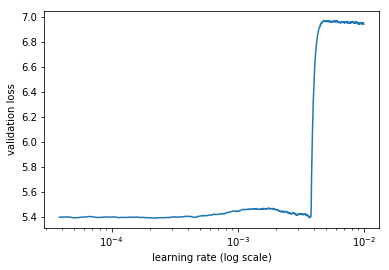

In [44]:
learner.sched.plot()

In [46]:
?learner.fit

In [47]:
lr = 1e-4
lrs = lr
learner.fit(lrs, n_cycle=1, wds=0, use_clr=(20,4), cycle_len=10)

epoch      trn_loss   val_loss                                
    0      5.285621   5.182443  
    1      5.200884   5.100977                                
    2      5.122614   5.029418                                
    3      5.064241   4.977073                                
    4      5.025035   4.942606                                
    5      4.992548   4.916353                                
    6      4.967907   4.897033                                
    7      4.950616   4.883063                                
    8      4.935099   4.87303                                 
    9      4.917032   4.859261                                


[4.859261114934783]

In [48]:
learner.save_encoder("lm1_enc")

In [49]:
learner.save("lm1")

In [50]:
del learner

## 3-class Classifier
As in https://zhuanlan.zhihu.com/p/27198713

### Full Dataset (v1)

In [17]:
for df in (df_train, df_val, df_test):
    df["label"] = (df["rating"] >= 3) * 1
    df.loc[df.rating == 3, "label"] = 1
    df.loc[df.rating > 3, "label"] = 2

In [18]:
df_train.label.value_counts()

2    240094
1    184124
0    104406
Name: label, dtype: int64

In [19]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.label.values)
val_ds = TextDataset(tokens_val, df_val.label.values)
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=False, num_workers=1, pad_idx=2, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=False, num_workers=1, pad_idx=2, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [20]:
model= get_transformer_classifier(
    n_tok=n_toks, 
    emb_sz=EMB_DIM, 
    n_head=12, 
    n_layer=3, 
    n_ctx=200,
    max_seq_len=100,
    clf_layers=[EMB_DIM, 50, 3],
    pad_token=2,
    embd_pdrop=0.1,
    attn_pdrop=0.1,
    resid_pdrop=0.1,
    clf_pdrop=[0.5, 0.1],
    afn="gelu"
)    

In [21]:
learn = TruncatedTransformerLearner(
    model_data, 
    TransformerTextModel(to_gpu(model)), 
    opt_fn=partial(torch.optim.Adam, betas=(0.9, 0.999)))
learn.clip=25
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

 81%|████████▏ | 13445/16520 [01:59<00:27, 112.93it/s, loss=3.26]

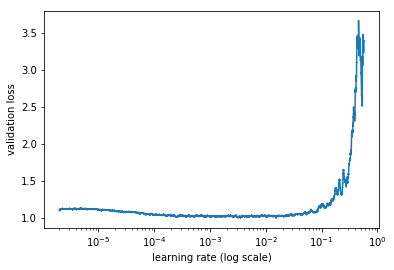

In [22]:
lrs = np.array([5e-5, 1e-4, 2e-4, 5e-4, 2e-3])
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [23]:
lrs = np.array([5e-5, 1e-4, 2e-4, 5e-4, 1e-3])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                         
    0      1.003765   1.00362    0.481545  


[1.003619710452808, 0.48154453827295013]

In [24]:
learn.save('clas_0')

In [25]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.913465   0.952717   0.51795   


[0.952716516158155, 0.5179503768273859]

In [26]:
learn.save('clas_1')

In [27]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                        
    0      0.875783   0.836878   0.603792  
    1      0.803205   0.80601    0.620063                        
    2      0.802037   0.792851   0.632996                        
    3      0.762536   0.787592   0.634494                        
    4      0.758367   0.794584   0.636867                        
    5      0.752415   0.799978   0.637031                        
 24%|██▍       | 3992/16520 [01:30<04:44, 43.97it/s, loss=0.726]

KeyboardInterrupt: 

In [ ]:
learn.save("clas_full")

#### Evaluate

In [38]:
learn.load("clas_full")
learn.model.reset()
_ = learn.model.eval()

In [40]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(val_dl):
    preds.append(np.argmax(learn.model(x).cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [41]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176208,), (176208,))

In [42]:
pd.Series(ys).value_counts()

2    80031
1    61374
0    34803
dtype: int64

In [43]:
pd.Series(preds).value_counts()

2    88966
1    59561
0    27681
dtype: int64

In [44]:
np.sum(ys==preds) / ys.shape[0]

0.6298749205484427

In [45]:
np.where(ys==0)

(array([    12,     15,     18, ..., 176198, 176202, 176207]),)

In [46]:
tokens_val[176196]

array([   1,  296,    4, 5142,    3, 1195,   13,   20,   16,    5, 3497,  326,    8,    3,   15,   82,  179])

In [47]:
sp.DecodeIds(tokens_val[176196].tolist()), df_val["comment"].iloc[176196]

('如此 的 欺骗 , 或许 我 也 就 释然 了 , 有 什么 呢', '如此 的 欺骗 ， 或许 我 也 就 释然 了 ， 有 什么 呢')

In [48]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + sp.EncodeAsIds(texts))).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()

In [49]:
get_prediction("看 了 快 一半 了 才 发现 是 mini 的 广告")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [50]:
get_prediction("妈蛋 ， 简直 太 好看 了 。 最后 的 DJ battle 部分 ， 兴奋 的 我 ， 简直 想 从 座位 上 站 起来 一起 扭")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [51]:
get_prediction("说 实话 我 没 怎么 认真 看 ， 电影院 里 的 熊 孩子 太 闹腾 了 ， 前面 的 小奶娃 还 时不时 站 "
               "在 老爸 腿上 蹦迪 ， 观影 体验 极差 ， 不过 小朋友 应该 挺 喜欢 的")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [52]:
get_prediction("这 电影 太 好笑 了 ， 说好 的 高科技 人才 研制 的 产品 永远 在 关键 时候 失灵 "
               "； 特地 飞 到 泰国 请来 救援 人才 ， 大家 研究 出 的 方法 每次 都是 先 给 鲨鱼 "
               "当 诱饵 … … 显然 这样 的 对战 坚持不了 多久 ， 只能 赶紧 让 鲨鱼 输 了 。")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [53]:
get_prediction("太 接地气 了 ， 在 三亚 煮饺子 式 的 景区 海域 ， 冒出来 一条 大 鲨鱼 "
               "… … 爽点 也 很 密集 ， 郭达森 与 李冰冰 的 CP 感 不错 ， 编剧 果然 是 "
               "老外 ， 中文 台词 有点 尬 。")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [54]:
get_prediction("李冰冰 的 脸 真的 很 紧绷 ， 比 鲨鱼 的 脸 还 绷 。")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [55]:
get_prediction("太 难 了 。 。 。")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [56]:
get_prediction("把 我 基神 写成 智障 ， 辣鸡 mcu")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [57]:
get_prediction("鲨鱼 部分 还是 不错 的 ， 尤其 是 中段 第一次 出海 捕鲨 非常 刺激 ， 其后 急速 下滑 ， "
               "三亚 那 部分 拍得 是什么 鬼 。 。 。 爆米花 片 可以 适度 的 蠢 ， 但 人类 反派 炸鲨 "
               "和 直升机 相撞 部分 简直 蠢得 太过份 了 吧 ？ 另外 充满 硬 加戏 视感 的 尴尬 感情戏 "
               "把 节奏 也 拖垮 了 ， 明明 可以 更 出色 ， 却 很遗憾 地 止步 在 马马虎虎 的 水平 。 6 / 10")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [58]:
get_prediction("老冰冰 真的 很努力 ！ 为 老冰冰 实现 了 她 的 好莱坞 女主梦 鼓掌 . . .")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [59]:
get_prediction("结局 简直 丧 出 天际 ！ 灭霸 竟然 有 内心戏 ！ 全程 下来 美队 "
               "和 钢铁侠 也 没 见上 一面 ， 我 还 以为 在 世界 末日 前 必然 "
               "要 重修 旧好 了 ！ ")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [60]:
get_prediction("太 烂 了 ， 难看 至极 。")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [61]:
get_prediction("看完 之后 很 生气 ！ 剧情 太差 了")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [62]:
get_prediction("关键点 都 好傻 ， 我 知道 你 要拍 续集 ， "
               "我 知道 未来 可以 被 重写 ， 但 那 一拳 真的 有点 傻 。")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [63]:
get_prediction("好了 可以 了 。 再也 不看 Marvel 了 。 我 努力 过 了 。 实在 是 。 。 啥呀 这是 。 🙄️")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

In [64]:
get_prediction("还 我 电影票 14 元")

array([-0.55734, -0.20844,  0.25577], dtype=float32)

Confusion matrix, without normalization
[[18011 11779  5013]
 [ 7181 31609 22584]
 [ 2489 16173 61369]]


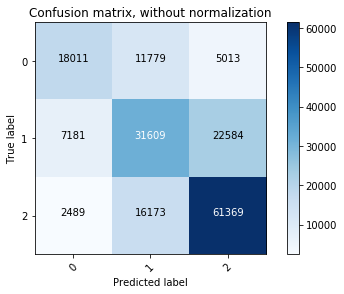

In [65]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.52 0.34 0.14]
 [0.12 0.52 0.37]
 [0.03 0.2  0.77]]


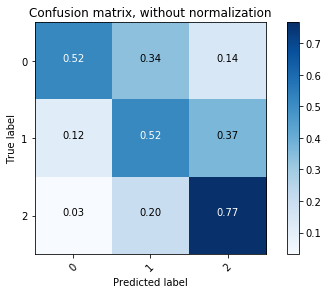

In [66]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [67]:
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 65%, R 52%, FS 0.58, Support: 34803
Class 1: P 53%, R 52%, FS 0.52, Support: 61374
Class 2: P 69%, R 77%, FS 0.73, Support: 80031


In [68]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=False, num_workers=1, pad_idx=0, sampler=test_samp)

In [71]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x).cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [72]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [73]:
np.sum(ys==preds) / ys.shape[0]

0.6287647055485248

Confusion matrix, without normalization
[[17802 11934  5066]
 [ 7232 31533 22610]
 [ 2497 16076 61459]]


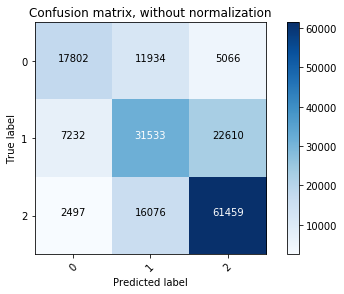

In [74]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.51 0.34 0.15]
 [0.12 0.51 0.37]
 [0.03 0.2  0.77]]


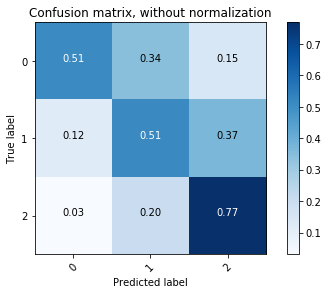

In [75]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [77]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 65%, R 51%, FS 0.57, Support: 34802
Class 1: P 53%, R 51%, FS 0.52, Support: 61375
Class 2: P 69%, R 77%, FS 0.73, Support: 80032


### Smaller Dataset 

In [21]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [22]:
df_train_small = pd.concat([
    df_train[df_train.label==0].sample(15000),
    df_train[df_train.label==1].sample(15000),
    df_train[df_train.label==2].sample(15000)
], axis=0)
df_val_small = pd.concat([
    df_val[df_val.label==0].sample(5000),
    df_val[df_val.label==1].sample(5000),
    df_val[df_val.label==2].sample(5000)
], axis=0)

In [23]:
np.array(df_train_small.index)

array([158141, 375121, 425516, ..., 470824, 232676,   7705])

In [50]:
bs = 64
tokens_train_small = np.array(tokens_train)[np.array(df_train_small.index)]
tokens_val_small = np.array(tokens_val)[np.array(df_val_small.index)]
trn_ds = TextDataset(tokens_train_small, df_train_small.label.values)
val_ds = TextDataset(tokens_val_small, df_val_small.label.values)
trn_samp = SortishSampler(tokens_train_small, key=lambda x: len(tokens_train_small[x]), bs=bs//2)
val_samp = SortSampler(tokens_val_small, key=lambda x: len(tokens_val_small[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=False, num_workers=1, pad_idx=2, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=False, num_workers=1, pad_idx=2, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [158]:
model= get_transformer_classifier(
    n_tok=n_toks, 
    emb_sz=EMB_DIM, 
    n_head=12, 
    n_layer=3, 
    n_ctx=200,
    max_seq_len=50,
    clf_layers=[EMB_DIM*3, 50, 3],
    pad_token=2,
    embd_pdrop=0.1,
    attn_pdrop=0.25,
    resid_pdrop=0.25,
    clf_pdrop=[0.5, 0.2],
    afn="gelu"
)    

In [159]:
learn = TruncatedTransformerLearner(
    model_data, 
    TransformerTextModel(to_gpu(model)), 
    opt_fn=partial(torch.optim.Adam, betas=(0.9, 0.999)))
learn.clip=25
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

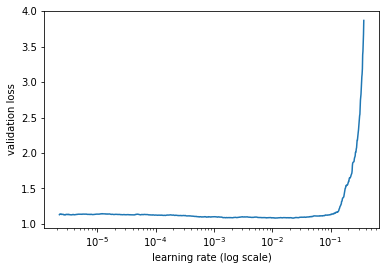

In [160]:
lrs = np.array([1e-5, 1e-4, 1e-4, 1e-4, 2e-4])
learn.freeze_to(-1)
learn.lr_find(lrs/100)
learn.sched.plot()

In [161]:
lrs = np.array([1e-5, 1e-4, 2e-4, 5e-4, 1e-3])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      1.063999   1.033606   0.459157  


[1.0336062614428398, 0.4591566388623]

In [162]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.04262    0.999248   0.485072  


[0.9992477037618771, 0.48507153357035415]

In [163]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                     
    0      1.027404   0.990906   0.497231  
    1      1.008221   0.98194    0.490684                      
    2      0.979416   0.986296   0.510467                      
    3      0.960566   0.947361   0.523323                      
    4      0.941711   0.963381   0.531863                      
    5      0.940463   0.958095   0.544123                      
    6      0.931123   0.955123   0.539445                      
    7      0.868991   0.954888   0.54505                       
    8      0.924406   0.954726   0.541312                      
    9      0.889994   0.966243   0.542699                      


[0.9662429381416122, 0.5426993595988158]

In [164]:
learn.save("clas_small_full")

In [166]:
learn.model.eval()
preds, ys = [], []
for x, y in val_dl:
    preds.append(np.argmax(learn.model(x).cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [167]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((15000,), (15000,))

Normalized confusion matrix
[[0.7  0.19 0.11]
 [0.35 0.35 0.31]
 [0.19 0.22 0.59]]


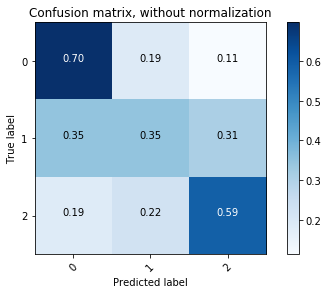

In [168]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [169]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [180]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x).cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [181]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [182]:
np.sum(preds==ys) / preds.shape[0]

0.5357388101629316

Normalized confusion matrix
[[0.7  0.19 0.11]
 [0.35 0.35 0.29]
 [0.18 0.21 0.61]]


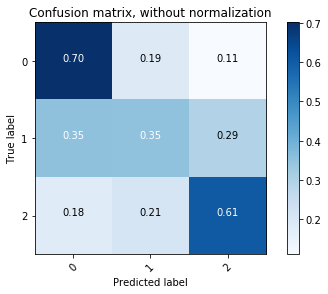

In [183]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [187]:
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 40%, R 70%, FS 0.51, Support: 34802
Class 1: P 48%, R 35%, FS 0.41, Support: 61375
Class 2: P 69%, R 61%, FS 0.64, Support: 80032


## Regressor

In [28]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.rating.values.astype("float32"))
val_ds = TextDataset(tokens_val, df_val.rating.values.astype("float32"))
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=False, num_workers=1, pad_idx=2, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=False, num_workers=1, pad_idx=2, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [29]:
tmp = next(iter(trn_dl))
tmp[0].size()

torch.Size([32, 325])

In [30]:
tmp[0][2, :300]

tensor([   2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,   

In [39]:
model= get_transformer_classifier(
    n_tok=n_toks, 
    emb_sz=EMB_DIM, 
    n_head=12, 
    n_layer=3, 
    n_ctx=200,
    max_seq_len=200,
    clf_layers=[EMB_DIM, 50, 1],
    pad_token=2,
    embd_pdrop=0.1,
    attn_pdrop=0.25,
    resid_pdrop=0.25,
    clf_pdrop=[0.5, 0.1],
    afn="gelu"
)    

In [40]:
class TruncatedTransformerRegLearner(TruncatedTransformerLearner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return lambda x, y: F.mse_loss(x[:, 0], y)

In [41]:
learn = TruncatedTransformerRegLearner(
    model_data, 
    TransformerTextModel(to_gpu(model)), 
    opt_fn=partial(torch.optim.Adam, betas=(0.9, 0.999)))
learn.clip=25
learn.load_encoder('lm1_enc')

 79%|███████▉  | 13037/16520 [02:07<00:34, 102.01it/s, loss=4.11]

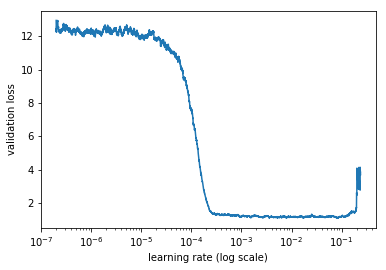

In [42]:
lrs = np.array([5e-5, 1e-4, 2e-4, 5e-4, 2e-4])
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [43]:
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_0')

epoch      trn_loss   val_loss                                  
    0      1.096065   1.086542  


In [44]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_1')

epoch      trn_loss   val_loss                                   
    0      0.982457   1.031254  


In [45]:
learn.unfreeze()
%time learn.fit(lrs, 1, wds=0, cycle_len=8, use_clr=(32,5))
learn.save('reg_full')

epoch      trn_loss   val_loss                                   
    0      0.867664   0.836235  
    1      0.761269   0.904029                                   
    2      0.750148   0.756387                                   
    3      0.716348   0.748697                                   
    4      0.737884   0.744667                                   
    5      0.665758   0.757192                                   
  3%|▎         | 419/16520 [00:11<07:04, 37.96it/s, loss=0.65] 

KeyboardInterrupt: 

In [37]:
# Export Model
torch.save(learn.model, path / "sentiment_model.pth")

In [38]:
learn.load('reg_full')

### Evaluation

In [121]:
test_ds = TextDataset(tokens_test, df_test.rating.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [122]:
def get_preds(data_loader):
    learn.model.eval()
    learn.model.reset()         
    preds, ys = [], []
    for x, y in tqdm_notebook(data_loader):   
        preds.append(learn.model(x)[0].cpu().data.numpy()[:, 0])
        ys.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    ys = np.concatenate(ys)
    return ys, preds
ys, preds = get_preds(val_dl)
preds.shape, ys.shape

((176208,), (176208,))

In [123]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [124]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [125]:
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6672458383699945

In [126]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6645135826693453

In [127]:
# Save predictions
df_val.loc[df_val.iloc[list(iter(val_samp))].index, "preds"] = preds
df_val.to_csv(path / "df_val.csv.gz", index=False, compression="gzip")
df_val.head()

,comment,rating,label,preds
0,男 主角 像 卡卡,2,0,3.259298
1,经典 改编 ， 还是 忠于 原著 的 ， 一路 都 很 稳 。,4,2,3.962335
2,叙事 ： 时间 空间 的 有机 结合,5,2,3.984771
3,看 街头 小 混混 打 外星人 挺 热闹 的 ， 可是 前 一 秒 还 在 抢劫 的 少年犯...,2,0,2.617926
4,这 电影 也 就 一般,3,1,2.664217


In [128]:
np.sum(np.square(df_val.rating.values - df_val.preds.values)) / preds.shape[0]

0.6645136139748985

In [129]:
ys, preds = get_preds(test_dl)
preds.shape, ys.shape

((176209,), (176209,))

In [130]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6696406409027693

In [131]:
# Save predictions
df_test.loc[df_test.iloc[list(iter(test_samp))].index, "preds"] = preds
df_test.to_csv(path / "df_test.csv.gz", index=False, compression="gzip")
df_test.head()

,comment,rating,label,preds
258461,无话可说 .,3,1,2.793769
118491,老师 你 太 可爱,5,2,3.972624
44768,说 了 好多 话 ， 可惜 都 是 陈词滥调 、 无 凭 无据 。,2,0,2.899381
34630,普巴 家用 的 电脑 是 苹果 。,3,1,3.418046
382761,这 才 是 一 部 看 完 之后 观众 讲 不 清道 不 明 的 电影 ， 主线 不 明了 ...,4,2,3.353409


In [132]:
df_test.sample(20)

,comment,rating,label,preds
842390,初中 的 时候 看 了 一 堆 007 的 VCD 。,3,1,3.232347
627523,现在 还 记得 张铁林 扮演 的 怡 亲王 。 。 。,5,2,3.298126
624264,一般 般,3,1,2.779430
113664,我 的 天 Higgs 已经 是 两 年 多 之前 的 事情 了 ................,5,2,4.072724
159047,在 不 知道 是 俄语 字幕 还是 爪 哇语 字幕 的 干扰 下 ， 欢快 的 啃生 肉 啃...,4,2,1.821184
219821,切入点 选 得 好 ， 反 高潮 ， 去 戏剧化 ， 斯皮尔伯格 难得 这么 克制 ， 只是...,4,2,3.595191
667673,几 个 细节 ： 1. 嫌犯 被捕 时 被 通知不宣 读 个人 权利 ， 审问 时 没有 律...,4,2,3.452877
637800,灰暗 ， 低沉 。,3,1,3.352764
258851,2.5 吧 。 看 在 老屈 的 面子 四 舍 五 入 一下 。 实在 是 一 部 类似 疾...,3,1,2.796375
594371,没 看 过 ， 但是 我 看 过 一些 数典忘祖 的 美 狗 日杂 ， 所以 五星,5,2,5.000000


In [133]:
np.sum(np.square(df_test.rating.values - df_test.preds.values)) / preds.shape[0]

0.6696406409027692

In [134]:
preds_class = np.round(preds)

Confusion matrix, without normalization
[[ 2295  4783  3571   831    42]
 [  928  8134 11832  2369    17]
 [  138  5062 35945 20023   207]
 [   19   758 15338 36985  1549]
 [   24   286  3694 18211  3168]]


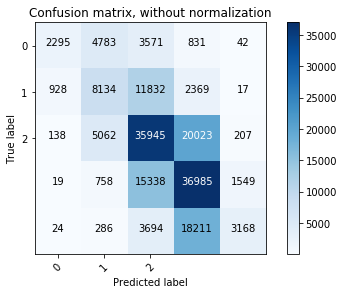

In [135]:
cnf_matrix = confusion_matrix(ys, preds_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

In [136]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds_class)
for i in range(5):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 67%, R 20%, FS 0.31, Support: 11522
Class 1: P 43%, R 35%, FS 0.38, Support: 23280
Class 2: P 51%, R 59%, FS 0.55, Support: 61375
Class 3: P 47%, R 68%, FS 0.56, Support: 54649
Class 4: P 64%, R 12%, FS 0.21, Support: 25383


In [137]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + sp.EncodeAsIds(texts))).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()[0, 0]

In [138]:
get_prediction("看 了 快 一半 了 才 发现 是 mini 的 广告")

2.5044014

In [139]:
get_prediction("妈蛋 ， 简直 太 好看 了 。 最后 的 DJ battle 部分 ， 兴奋 的 我 ， 简直 想 从 座位 上 站 起来 一起 扭")

4.534949

In [140]:
get_prediction("关键点 都 好傻 ， 我 知道 你 要拍 续集 ， "
               "我 知道 未来 可以 被 重写 ， 但 那 一拳 真的 有点 傻 。")

2.3158228

In [141]:
get_prediction("李冰冰 的 脸 真的 很 紧绷 ， 比 鲨鱼 的 脸 还 绷 。")

3.0249376

In [142]:
get_prediction("太 烂 了 ， 难看 至极 。")

1.3973805

In [143]:
get_prediction("看完 之后 很 生气 ！ 剧情 太差 了")

2.4281068

In [144]:
get_prediction("好了 可以 了 。 再也 不看 Marvel 了 。 我 努力 过 了 。 实在 是 。 。 啥呀 这是 。 🙄️")

3.234384

In [145]:
get_prediction("还 我 电影票 14 元")

2.522077